In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor
from tqdm.notebook import tqdm
from math import sqrt
import joblib
from tqdm.notebook import tqdm
import seaborn as sns
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


# load data

In [2]:
dataset = joblib.load('./data/dataset_for_cnn_model')
X = dataset['X']
y = dataset['y']
i_lst = dataset['index']

In [3]:
print(X.shape)
print(y.shape)

(130922, 6, 83)
(130922,)


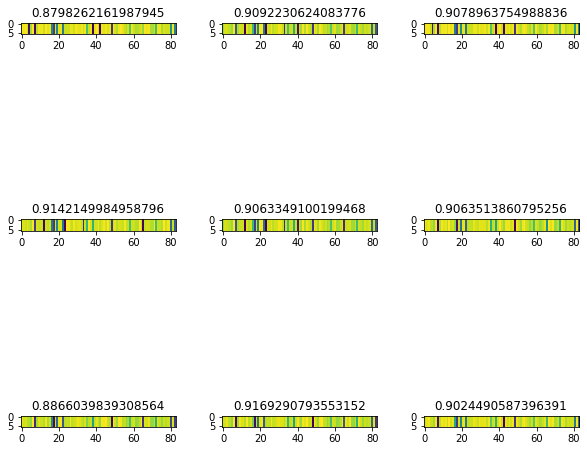

In [4]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0.3, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    idx = np.random.randint(0,len(X))
    plt.imshow(X[idx])
    plt.title(y[idx])

# Triple Barrier

In [5]:
import numpy as np
import math
def triple_barrier(price, ub, lb, max_period):

    def end_price(s):
        return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
    
    r = np.array(range(max_period))
    
    def end_time(s):
        return np.append(r[(s / s[0] > ub) | (s / s[0] < lb)], max_period-1)[0]

    p = price.rolling(max_period).apply(end_price, raw=True).shift(-max_period+1)
    t = price.rolling(max_period).apply(end_time, raw=True).shift(-max_period+1)
    t = pd.Series([t.index[int(k+i)] if not math.isnan(k+i) else np.datetime64('NaT') 
                   for i, k in enumerate(t)], index=t.index).dropna()

    signal = pd.Series(0, p.index)
    signal.loc[p > ub] = 1
    signal.loc[p < lb] = -1
    ret = pd.DataFrame({'triple_barrier_profit':p, 'triple_barrier_sell_time':t, 'triple_barrier_signal':signal})

    return ret

ret = triple_barrier(y, 1.03, 0.97, 6)

In [6]:
ret.head()

,triple_barrier_profit,triple_barrier_sell_time,triple_barrier_signal
2016-05-23 15:20:00,1.012827,2016-05-23 16:10:00,0
2016-05-23 15:30:00,1.009124,2016-05-23 16:20:00,0
2016-05-23 15:40:00,1.010915,2016-05-23 16:30:00,0
2016-05-23 15:50:00,1.007931,2016-05-23 16:40:00,0
2016-05-23 16:00:00,1.004589,2016-05-23 16:50:00,0


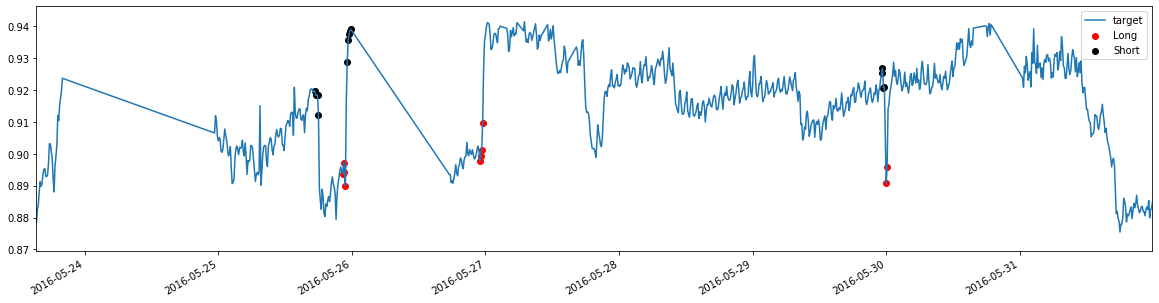

In [7]:
fig = plt.figure(figsize=(20,5))

date = '2016-05'

y[date].plot(label='target')

L = ret['triple_barrier_signal'] == 1
S = ret['triple_barrier_signal'] == -1

plt.scatter(y.loc[L].index,y.loc[L],color='red',label='Long')
plt.scatter(y.loc[S].index,y.loc[S],color='black',label='Short')

plt.legend()

In [8]:
ret['triple_barrier_signal'].value_counts()

 0    129066
-1      1003
 1       853
Name: triple_barrier_signal, dtype: int64

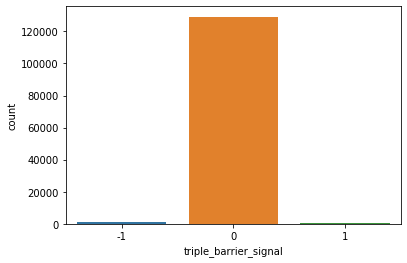

In [9]:
sns.countplot(ret['triple_barrier_signal'])

# 調整採樣

In [10]:
#class_sample_num = ret['triple_barrier_signal'].value_counts().min()
#print(class_sample_num)

#y1 = y.loc[L].sample(class_sample_num)
#y2 = y.loc[S].sample(class_sample_num)
#y3 = y.loc[(~L)&(~S)].sample(class_sample_num*3)
#temp = y1.append(y2).append(y3)

#new_index = []
#origin_index = y.index.tolist()
#for idx in tqdm(temp.index):
#    new_index.append(origin_index.index(idx))

#X = X[new_index,:]
#y = temp
#print(X.shape)
#print(y.shape)

2016-05-23 15:20:00    0
2016-05-23 15:30:00    0
2016-05-23 15:40:00    0
2016-05-23 15:50:00    0
2016-05-23 16:00:00    0
Name: triple_barrier_signal, dtype: int64


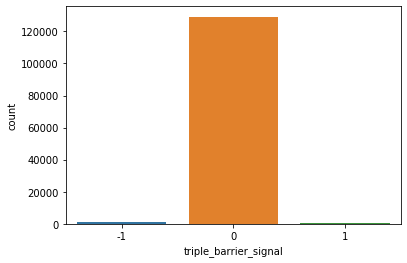

In [11]:
y_values = y
y = ret['triple_barrier_signal'].loc[y.index]
print(y.head())
sns.countplot(y)

In [12]:
i_lst = y.index

# save dataset

In [13]:
dataset = {}
dataset['X'] = X
dataset['y'] = y
dataset['y_values'] = y_values
dataset['index'] = i_lst

joblib.dump(dataset,'./data/dataset_categorical')

['./data/dataset_categorical']